In [37]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pygsp as pg
import learnHeat as lh
from pygsp import plotting
from scipy.linalg import expm
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

We will try to do a simple example, let's take a delta for each node and evolve it with time

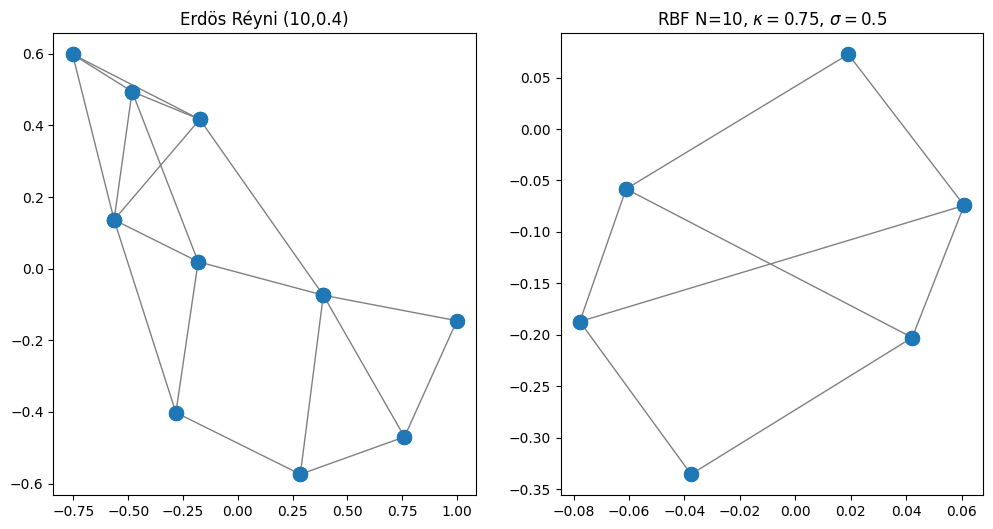

In [108]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
plotting.plot_graph(G3,ax=ax[0],plot_name="Erdös Réyni (10,0.4)")
plotting.plot_graph(G4,ax=ax[1],plot_name="RBF N=10, $\kappa = 0.75$, $\sigma=0.5$")
plt.savefig("images/4graphs2.png",format="png")

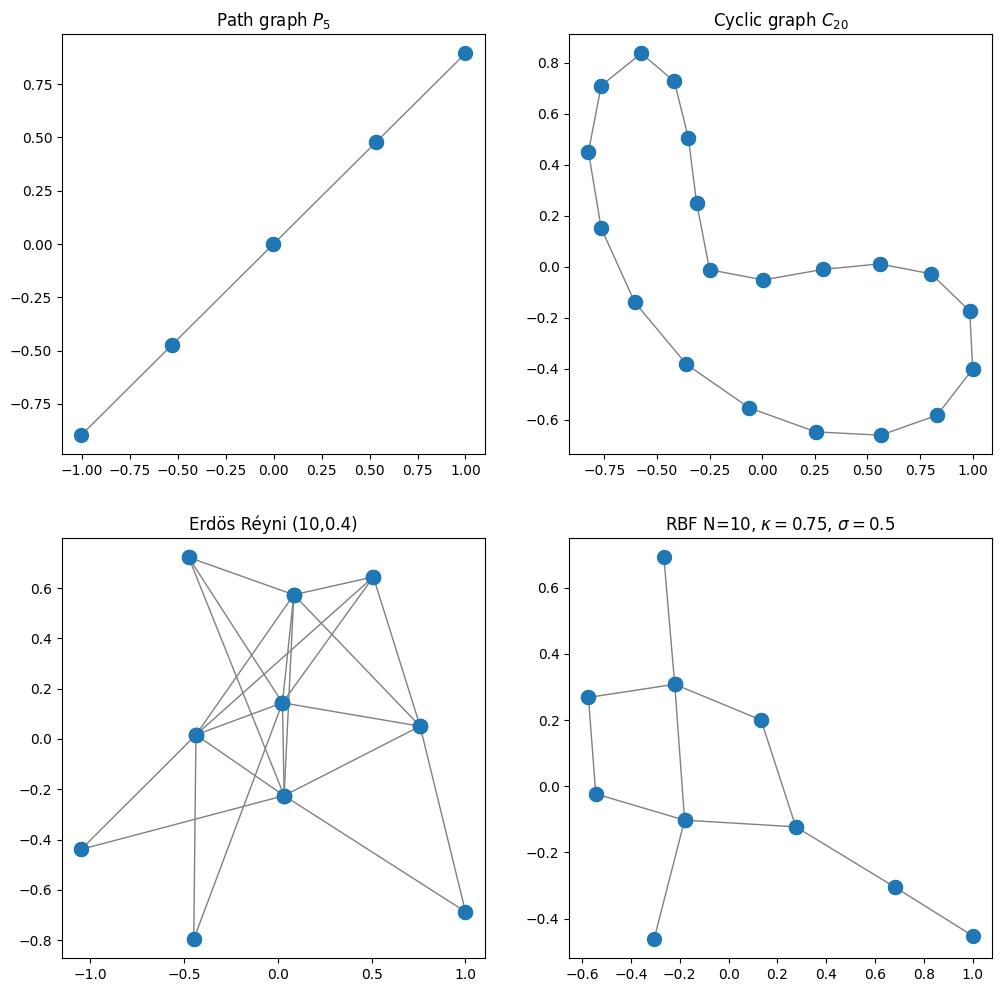

In [38]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
plotting.plot_graph(G,ax=ax[0,0],plot_name="Path graph $P_5$")
plotting.plot_graph(Gring,ax=ax[0,1],plot_name="Cyclic graph $C_{20}$")
plotting.plot_graph(G3,ax=ax[1,0],plot_name="Erdös Réyni (10,0.4)")
plotting.plot_graph(G4,ax=ax[1,1],plot_name="RBF N=10, $\kappa = 0.75$, $\sigma=0.5$")
plt.savefig("images/4graphs.png",format="png")

In [100]:
N = 5 # number of nodes for our graph
G = pg.graphs.Path(N) # create path graph with N nodes
G.set_coordinates()

Deltas are the columns here

In [40]:
H = np.eye(N)

Take third column and plot it

Text(0.5, 1.0, 'Signal at time t=0')

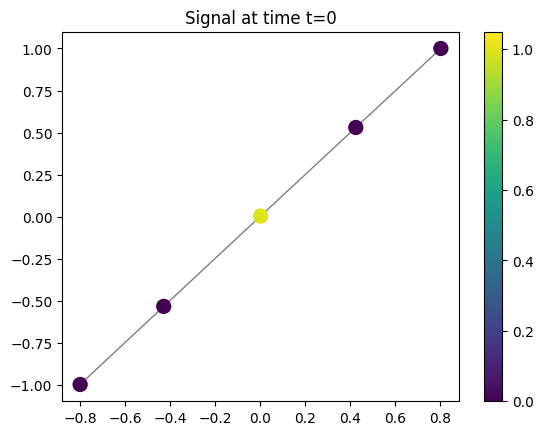

In [41]:
plotting.plot_signal(G,H[:,2])
plt.title("Signal at time t=0")

Let's evolve each signal $\tau=[1,2.5,4]$ units of time

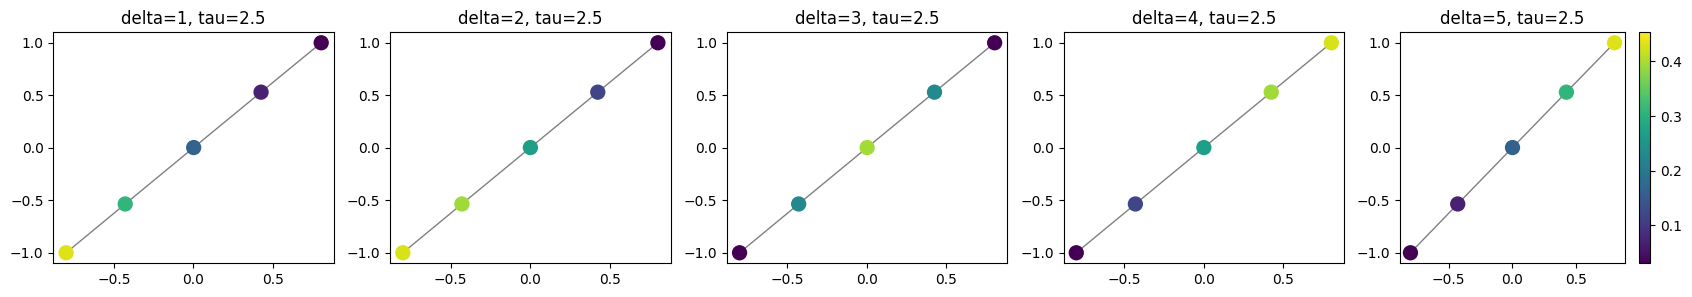

In [42]:
# extract the Laplacian from the line graph
L = G.L.toarray()
L = L/np.trace(L)*(L.shape[0])
# evolve the eye signal
signals = []
taus = [1,2.5,4]
for tau in taus:
    signals.append(expm(-tau*L)@H)

# plotting stuff
fig, axs = plt.subplots(1, 5, figsize=(21, 3))
for i in range(5):
    ax = axs[i]
    if i!=4:
        color = False
    else:
        color = True
    plotting.plot_signal(G,signals[1][:,i],ax=ax,colorbar=color,plot_name="delta={}, tau={}".format(i+1,2.5))
plt.savefig('images/evolved_deltas.png',format='png')

Trying to learn from the diffused signal

In [43]:
import learnHeat as lh
# concatenate created signals
X = np.concatenate([signal for signal in signals], axis=1)
# create random graph and Laplacian
M = X.shape[1]

_, L0, H0, tau0 = lh.create_signal(N=N,tau_ground=[1,2,3],M=M,se=0.1)

In [44]:
import array_to_latex

In [45]:
array_to_latex.to_ltx(X)

\begin{bmatrix}
  0.63 &  0.28 &  0.08 &  0.01 &  0.00 &  0.43 &  0.31 &  0.16 &  0.07 &  0.03 &  0.35 &  0.28 &  0.19 &  0.11 &  0.07\\
  0.28 &  0.42 &  0.22 &  0.06 &  0.01 &  0.31 &  0.29 &  0.21 &  0.12 &  0.07 &  0.28 &  0.25 &  0.20 &  0.15 &  0.11\\
  0.08 &  0.22 &  0.41 &  0.22 &  0.08 &  0.16 &  0.21 &  0.25 &  0.21 &  0.16 &  0.19 &  0.20 &  0.21 &  0.20 &  0.19\\
  0.01 &  0.06 &  0.22 &  0.42 &  0.28 &  0.07 &  0.12 &  0.21 &  0.29 &  0.31 &  0.11 &  0.15 &  0.20 &  0.25 &  0.28\\
  0.00 &  0.01 &  0.08 &  0.28 &  0.63 &  0.03 &  0.07 &  0.16 &  0.31 &  0.43 &  0.07 &  0.11 &  0.19 &  0.28 &  0.35
\end{bmatrix}


In [46]:
L0

array([[ 1,  0,  0,  0, -1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  1,  0, -1],
       [ 0,  0,  0,  0,  0],
       [-1,  0, -1,  0,  2]])

In [47]:
X.shape[:],L.shape[:],H.shape[:],len(taus) # H shape is wrong

((5, 15), (5, 5), (5, 5), 3)

In [48]:
result = lh.learn_heat(X = X, 
                    L0=L, H0 = np.random.rand(15,15), tau0=[1,2,3], 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.0)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [49]:
result["L"]

array([[ 0.56462, -0.56462,  0.     ,  0.     ,  0.     ],
       [-0.56462,  0.82319, -0.25856,  0.     ,  0.     ],
       [ 0.     , -0.25856,  0.37415, -0.11559,  0.     ],
       [ 0.     ,  0.     , -0.11559,  1.67682, -1.56123],
       [ 0.     ,  0.     ,  0.     , -1.56123,  1.56123]])

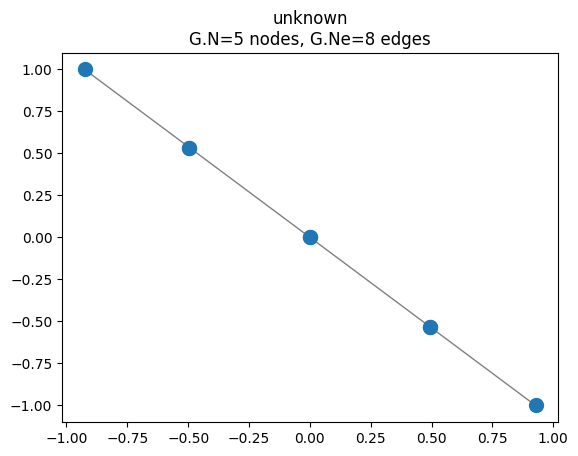

In [76]:
Lres = result["L"]
Lres[abs(Lres)<0.01] = 0
Adj = -np.copy(result["L"])
np.fill_diagonal(Adj, 0)
G_learned = pg.graphs.Graph(Adj)
G_learned.set_coordinates()
plotting.plot_graph(G_learned)

Now for the same graph, can we do the same technique with noise?

In [51]:
se = 0.1 # standard deviation
noisyX = X + se*np.random.randn(X.shape[0],X.shape[1])
noisy_result = lh.learn_heat(X = X, 
                    L0=L, H0 = np.random.rand(15,15), tau0=[1,2,3], 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.01)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

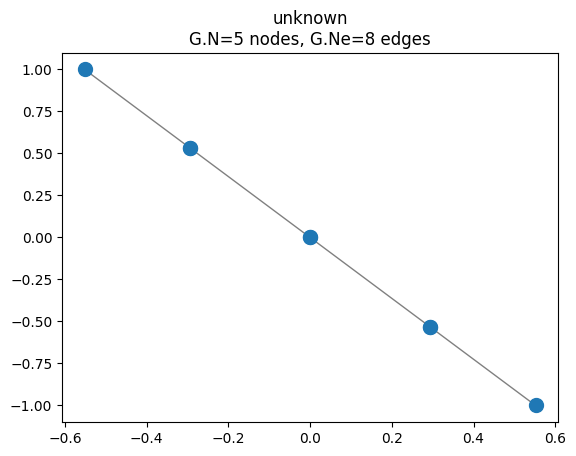

In [52]:
# do the same
noisy_Lres = result["L"]
noisy_Lres[abs(Lres)<0.01] = 0
noisy_Adj = -np.copy(result["L"])
np.fill_diagonal(noisy_Adj, 0)
noisy_G_learned = pg.graphs.Graph(noisy_Adj)
noisy_G_learned.set_coordinates()
plotting.plot_graph(noisy_G_learned)

Can we do the same with an arbitrary graph?

Let's create a random bigger graph with $N=20$ as in the paper.

In [53]:
from importlib import reload
lh = reload(lh)
big_N = 20
big_graph = nx.gnp_random_graph(big_N,p=0.4)
big_L = nx.laplacian_matrix(big_graph).toarray()
# we should normalize
big_L = big_L/np.trace(big_L)*big_N
big_tau = [0.5,1,1.5,2,3]
big_X = lh.create_deltas(big_L,big_tau,se=0)

Let's create false L, H, $\tau$ to feed the algorithm together with the noisy signal

In [54]:
big_M = big_X.shape[1]
_, not_L, not_H, not_tau = lh.create_signal(N=big_N,M=big_M,tau_ground=big_tau)

In [55]:
big_res = lh.learn_heat(X=big_X,L0=not_L,H0=not_H,tau0=not_tau,alpha=0.05,beta=0.05,max_iter=50)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [56]:
big_L_learned = big_res["L"]
# create adjacency
big_W = -big_L_learned
np.fill_diagonal(big_W,0)
# cap with some threshold
big_W[abs(big_W)<0.01]=0

In [57]:
big_tp = np.sum((big_W>0)&(big_L<0))
big_fp = np.sum((big_W>0)&(big_L>=0))
big_fn = np.sum((big_W<=0)&(big_L<0))

In [58]:
precision = big_tp/(big_tp+big_fp)

In [59]:
recall = big_tp/(big_tp+big_fn)

In [60]:
f_measure = 2/(1/precision + 1/recall)
f_measure
# we obtain 0.75 it is ok

0.7474747474747475

Finally, we will try to learn a ring!!!

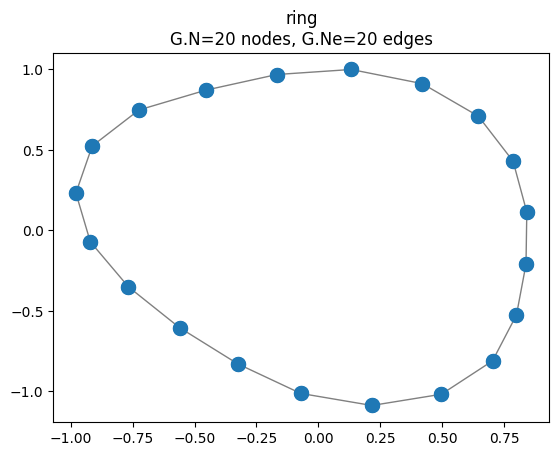

In [101]:
Nring = 20
Gring = pg.graphs.Ring(Nring,1)
Gring.set_coordinates()
plotting.plot_graph(Gring)

In [62]:
Lring = Gring.L.todense()
Lring = Lring/np.trace(Lring)*Lring.shape[0]
tauring = [0.5,1,1.5,5]
Xring = lh.create_deltas(Lring,tauring)

_, notLring, Hring, tauring = lh.create_signal(N=Lring.shape[0],M=Xring.shape[1],tau_ground=tauring)

In [63]:
resring = lh.learn_heat(X=Xring,L0=notLring,H0=Hring,tau0=[1,1,1,2],alpha=0.05,beta=0.05,max_iter=50)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

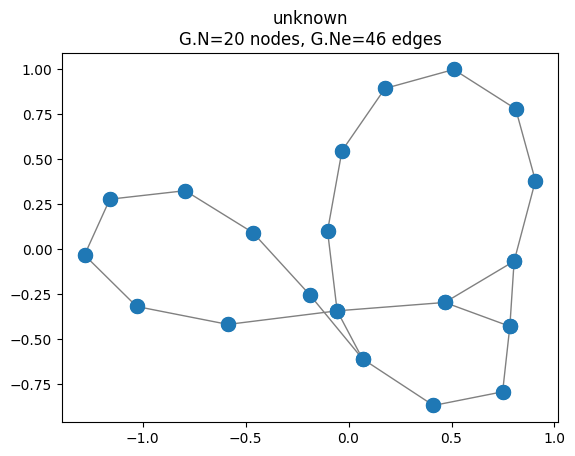

In [81]:
learned_ring = -resring["L"]
np.fill_diagonal(learned_ring,0)
# do a film on threshold
learned_ring[learned_ring < 0.17] = 0
Glearnedring = pg.graphs.Graph(learned_ring)
Glearnedring.set_coordinates()
plotting.plot_graph(Glearnedring)

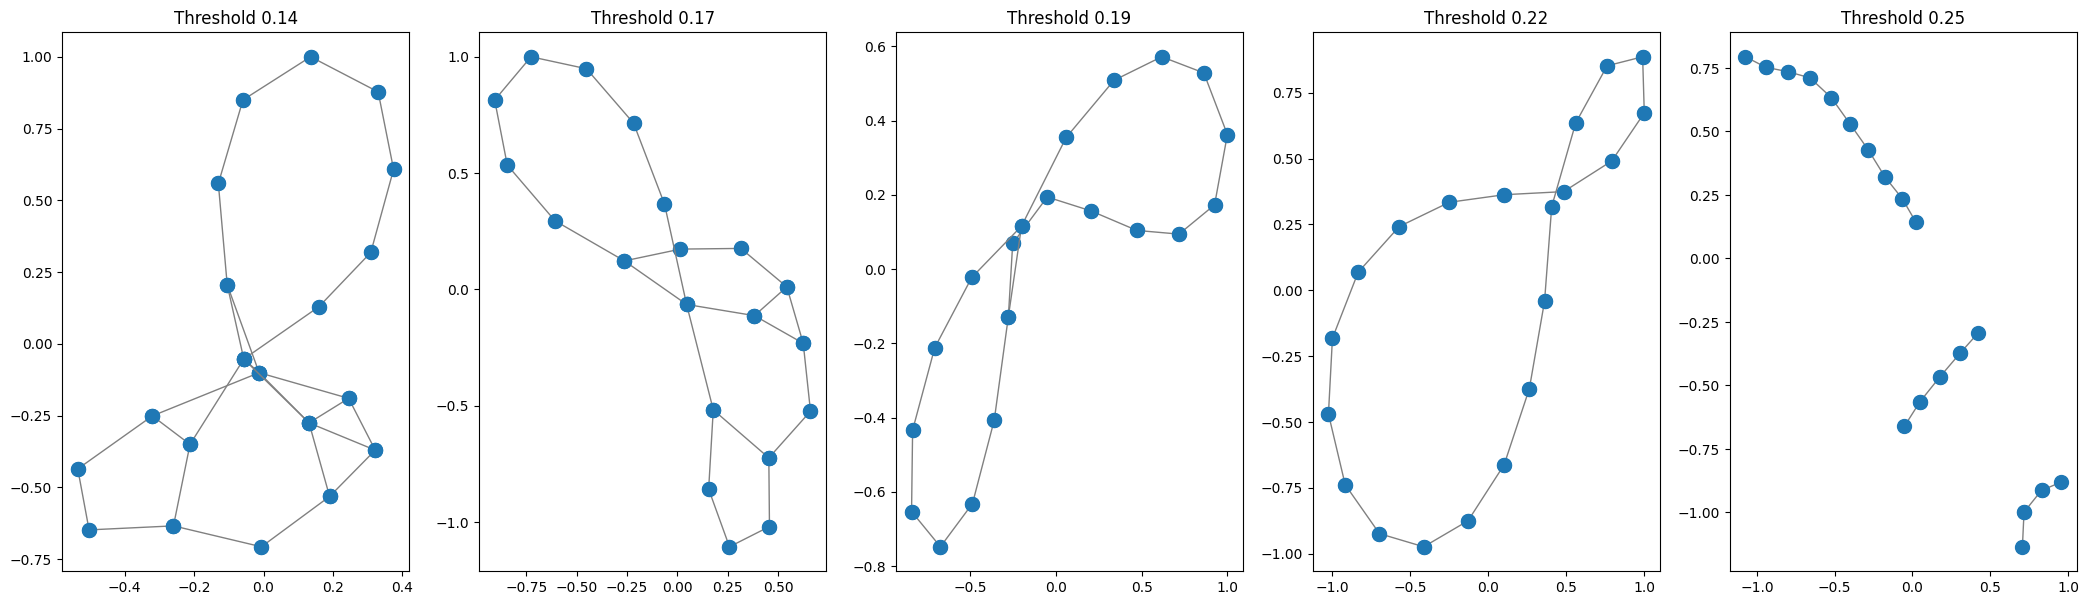

In [128]:
threshold = np.linspace(0,0.25,10)
fig1, ax1 = plt.subplots(1,5,figsize=(26,7))
for i in range(5,10):
    learned_ring = -resring["L"]
    np.fill_diagonal(learned_ring,0)
    # do a film on threshold
    learned_ring[learned_ring < threshold[i]] = 0
    Glearnedring = pg.graphs.Graph(learned_ring)
    Glearnedring.set_coordinates()
    plotting.plot_graph(Glearnedring,ax=ax1[i-5],plot_name="Threshold {}".format(np.round(threshold[i],2)))
plt.savefig("images/threshold2.png")

Final simple examples
### Trying to learn an Erdos Renyi graph

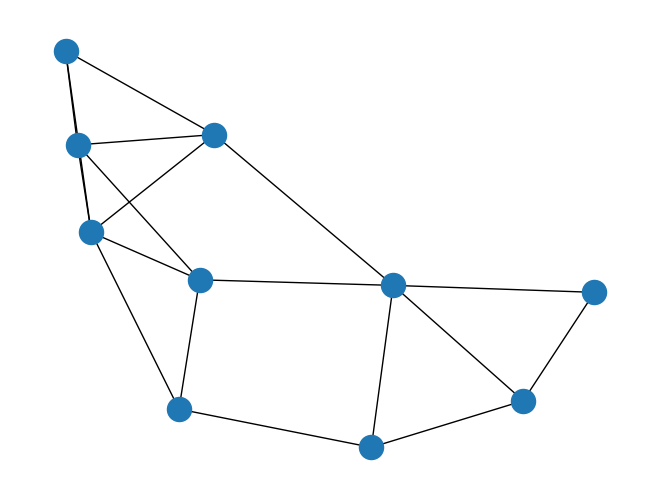

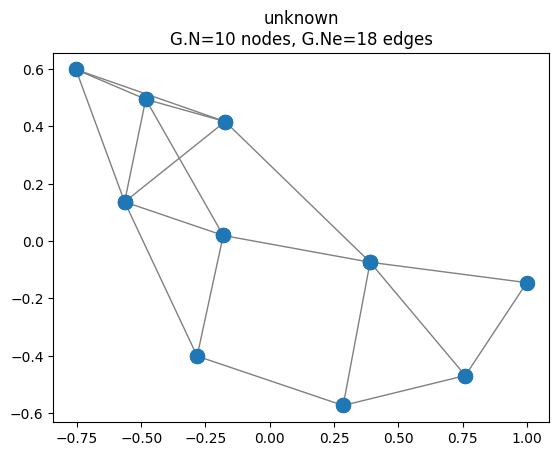

In [65]:
G = nx.erdos_renyi_graph(10,0.4)
tau_ground = [0.5,1,2.5,4]
nx.draw(G)
L = nx.laplacian_matrix(G).toarray()
W = nx.adjacency_matrix(G).toarray()
G3 = pg.graphs.Graph(W)
G3.set_coordinates()
plotting.plot_graph(G3)

In [66]:
X = lh.create_deltas(L,tau_ground)

In [86]:
res = lh.learn_heat(X=X,tau0=[1,2,3,4],alpha=0.05,beta=0.02,max_iter=75)

Learning progress:   0%|          | 0/75 [00:00<?, ?it/s]

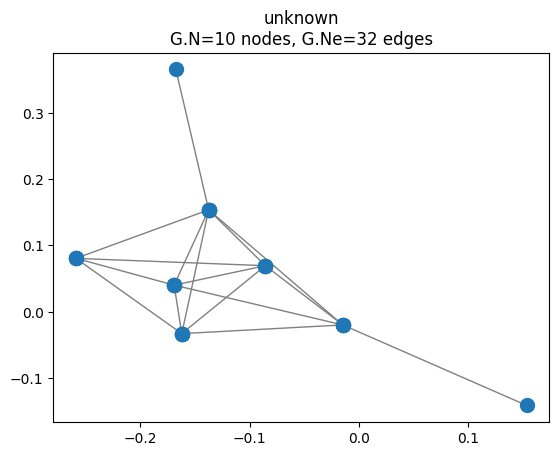

In [87]:
W = -res["L"]
np.fill_diagonal(W,0)
W[W<0.1] = 0
G_learned2=pg.graphs.Graph(W)
G_learned2.set_coordinates()
plotting.plot_graph(G_learned2)

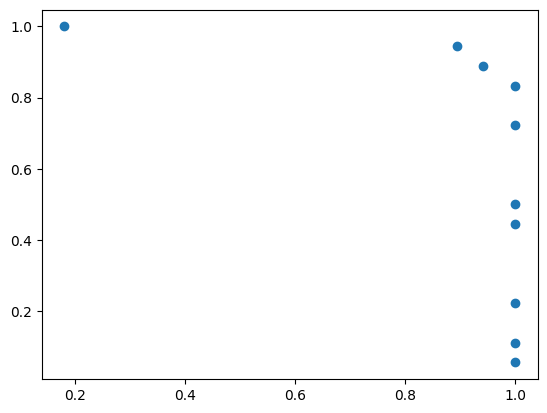

In [69]:
precision, recall = lh.heat_scores(res["L"],L)
plt.scatter(precision,recall)

Doing the same with an RBF graph

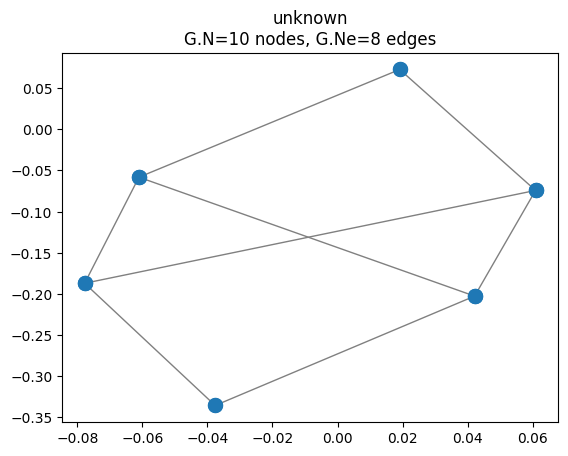

In [70]:
_, L, _, _ = lh.create_signal2(N=10,se=0)
W4 = -L
np.fill_diagonal(W4,0)
G4 = pg.graphs.Graph(W4)
G4.set_coordinates()
plotting.plot_graph(G4)

In [71]:
X = lh.create_deltas(L,tau_ground)

Learning progress:   0%|          | 0/75 [00:00<?, ?it/s]

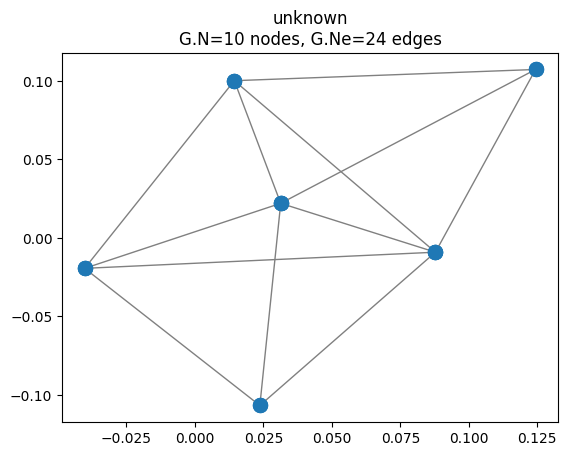

In [82]:
res = lh.learn_heat(X=X,tau0=[1,2,3,4],alpha=0.05,beta=0.02,max_iter=75)
W = -res["L"]
np.fill_diagonal(W,0)
W[W<0.1] = 0
G_learned3=pg.graphs.Graph(W)
G_learned3.set_coordinates()
plotting.plot_graph(G_learned3)

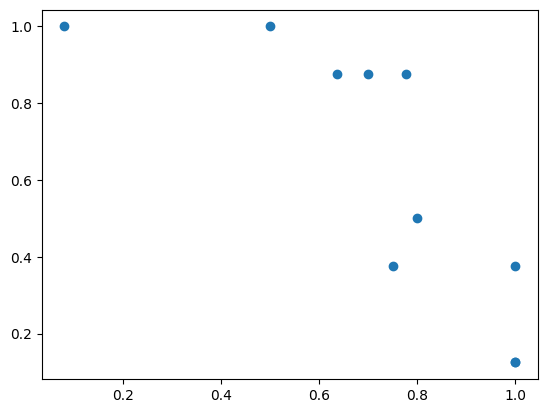

In [73]:
precision, recall = lh.heat_scores(res["L"],L)
plt.scatter(precision,recall)

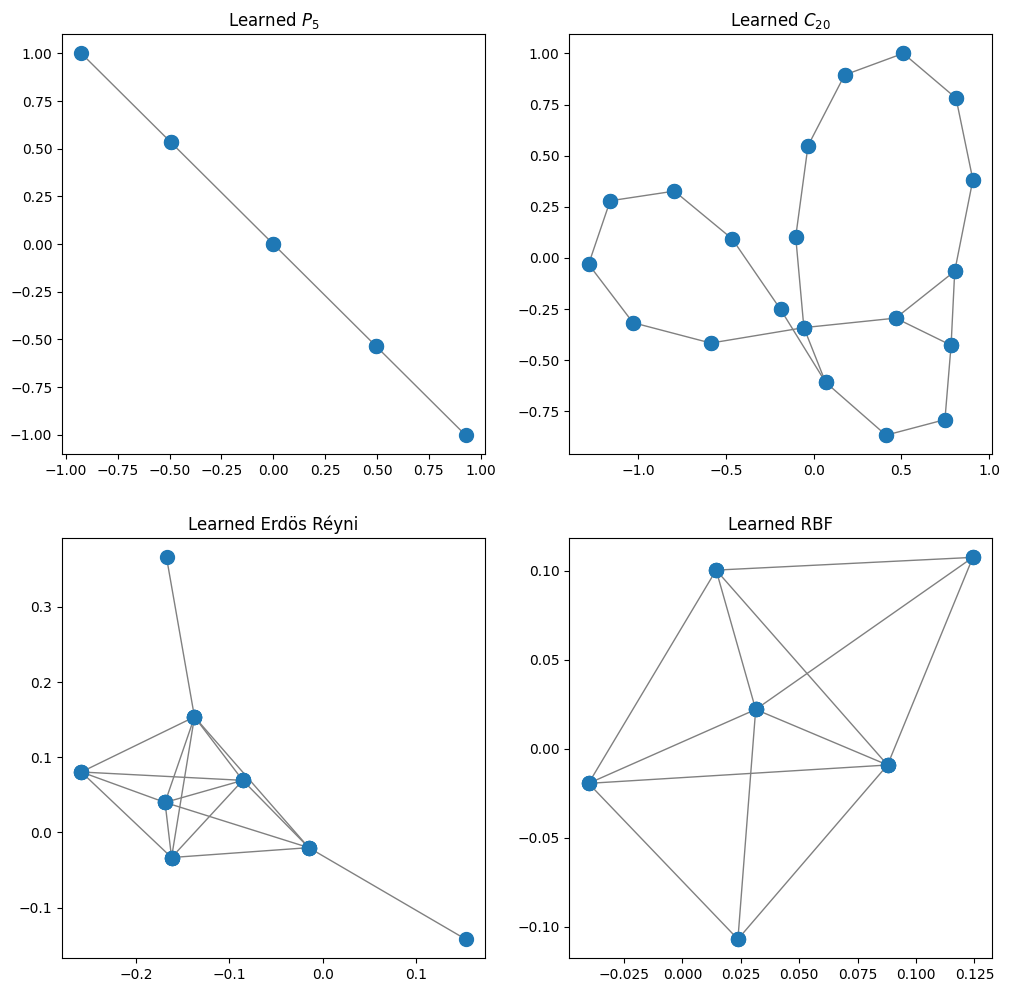

In [92]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
plotting.plot_graph(G_learned,ax=ax[0,0],plot_name="Learned $P_5$")
plotting.plot_graph(Glearnedring,ax=ax[0,1],plot_name="Learned $C_{20}$")
plotting.plot_graph(G_learned2,ax=ax[1,0],plot_name="Learned Erdös Réyni")
plotting.plot_graph(G_learned3,ax=ax[1,1],plot_name="Learned RBF")
plt.savefig("images/4learnedgraphs.png",format="png")


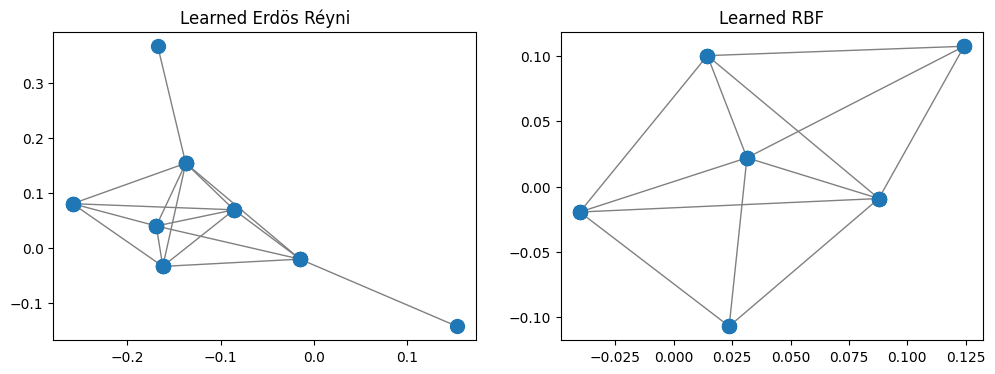

In [97]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plotting.plot_graph(G_learned2,ax=ax[0],plot_name="Learned Erdös Réyni")
plotting.plot_graph(G_learned3,ax=ax[1],plot_name="Learned RBF")
plt.savefig("images/4learnedgraphs2.png",format="png")
